In [1]:
#!pip install impyute
#pip install ipywidgets
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#!pip install Pipeline

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import pandas as pd
import time
import random
import numpy as np
from numpy import quantile, where
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import missingno as msno
import itertools
from pandas_profiling import ProfileReport
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.impute import SimpleImputer
from  sklearn.neighbors import LocalOutlierFactor
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from impyute.imputation.cs import fast_knn, mice
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import LimeTabular
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from imblearn.over_sampling import SMOTE, SMOTENC
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

import sys
sys.path.append('../..')

### 1. Import Data

In [91]:
hmda_file = '../../data/hmda_lar/cleaned_data/1_cleaned_hmda_2021_stage1_Full.csv'
with open(hmda_file) as f:
    ncols = len(f.readline().split(','))

hmda_df = pd.read_csv(hmda_file, usecols=[i for i in range(2,ncols)]) # Removing lei and census track from import

hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867978 entries, 0 to 3867977
Data columns (total 36 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   conforming_loan_limit                     float64
 1   purchaser_type                            int64  
 2   lien_status                               int64  
 3   open_end_line_of_credit                   int64  
 4   business_or_commercial_purpose            int64  
 5   loan_amount                               int64  
 6   combined_loan_to_value_ratio              float64
 7   hoepa_status                              int64  
 8   loan_term                                 float64
 9   interest_only_payment                     int64  
 10  property_value                            float64
 11  occupancy_type                            int64  
 12  manufactured_home_secured_property_type   int64  
 13  manufactured_home_land_property_interest  int64  
 14  in

#####################################################3

In [92]:

Categorical = pd.DataFrame(hmda_df.apply(pd.Series.nunique))
Categorical.reset_index(inplace=True)

In [93]:
for dd in range(0,len(Categorical)):
    if Categorical.iloc[dd,1]<15 and Categorical.iloc[dd,0]!='loan_outcome': # defined that if a variable with less than 15 categories are categorical
        cat = Categorical.iloc[dd,0]
        hmda_df[cat]= hmda_df[cat].astype('category')

In [94]:
hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867978 entries, 0 to 3867977
Data columns (total 36 columns):
 #   Column                                    Dtype   
---  ------                                    -----   
 0   conforming_loan_limit                     category
 1   purchaser_type                            category
 2   lien_status                               category
 3   open_end_line_of_credit                   category
 4   business_or_commercial_purpose            category
 5   loan_amount                               int64   
 6   combined_loan_to_value_ratio              float64 
 7   hoepa_status                              category
 8   loan_term                                 float64 
 9   interest_only_payment                     category
 10  property_value                            float64 
 11  occupancy_type                            category
 12  manufactured_home_secured_property_type   category
 13  manufactured_home_land_property_interest  

In [8]:
profile = ProfileReport(hmda_df, minimal=True)
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\multimethod\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
vantage3 = hmda_df[hmda_df['applicant_credit_score_type']==6]

looks at the Approval (1)/denial (0) of Loans that used Vantage Credit Score model. App_race defined as below
- 1: Native American
- 2: Asian
- 3: Black
- 4: Pacific Islander
- 5: White
- 6: Latino

In [110]:
vantage3.groupby(by=['app_race_ethnicity', 'loan_outcome'])['loan_amount'].count()


app_race_ethnicity  loan_outcome
1.0                 0                1809
                    1                 523
2.0                 0                2557
                    1                3448
3.0                 0               14738
                    1                3822
4.0                 0                 114
                    1                  59
5.0                 0               43699
                    1               39177
6.0                 0               12118
                    1                5781
Name: loan_amount, dtype: int64

In [108]:
FICO = hmda_df[(hmda_df['applicant_credit_score_type']==1) | (hmda_df['applicant_credit_score_type']==2) | (hmda_df['applicant_credit_score_type']==3) | (hmda_df['applicant_credit_score_type']==4)]

looks at the Approval (1)/denial (0) of Loans that used FICO Credit Score model. App_race defined as below
- 1: Native American
- 2: Asian
- 3: Black
- 4: Pacific Islander
- 5: White
- 6: Latino

In [111]:

FICO.groupby(by=['app_race_ethnicity', 'loan_outcome'])['loan_amount'].count()


app_race_ethnicity  loan_outcome
1.0                 0                  3851
                    1                 14716
2.0                 0                 27684
                    1                323461
3.0                 0                 50282
                    1                166142
4.0                 0                   687
                    1                  4913
5.0                 0                184629
                    1               2017193
6.0                 0                 61430
                    1                342238
Name: loan_amount, dtype: int64

### Feature selection for do One-Hot-Encoding

In [9]:
def create_dummy_vars(df, columns, added_cols):
    '''
    Create dummy variables based on values being isolated in the list of dict being passed
    '''

    for column in columns:
        dummy_vars = columns[column]

        for dummy_var in dummy_vars:

            var_value = dummy_vars[dummy_var]

            df.loc[(df[column].isin(var_value)), dummy_var] = 0
            df.loc[~(df[column].isin(var_value)), dummy_var] = 1
            added_cols.append(dummy_var)

    return df, added_cols


In [10]:
one_hot_cols = [                   
                   ### reference: Conforming
                   {'conforming_loan_limit': {'Nonconforming': [2], 'Undetermined': [3]}},

                   ### reference: no cover loan purchase
                   {'purchaser_type': {'gov_sponsored_loan_pchase': [1, 2, 3, 4],
                                       'banks_mtg_loan_pchase':[6, 71], 'othr_loan_pchase':[72, 8, 9]}},
                   
                   
                    ### Reference: No_Coapplicant
                   {'coapp_race_ethnicity': {'coapp_white': [5], 'coapp_black': [3], 'coapp_latino': [6], 'coapp_asian': [2], 'coapp_native': [1],
                                             'coapp_pac_islander': [4]
                                             }}, #using a different column to determine whether a co-applicant participated in the loan

                    ### Reference: Coapplicant
                   {'co_applicant_sex': { 'coapp_female': [2]}}, #using a different column to determine whether a co-applicant participat 'coapp_male': [1],

                   ### reference: other loan purposes
                   #{'loan_purpose': {'home_purchase': [1], 'home_improve_ppose': [2], 'refinancing_ppose':[31, 32]
                                     #, 'othr_ppose':[4, 5] }},
                   
                    ### reference: Secured by a first lien
                   {'lien_status': {'subord_lien_loan_sec': [2]}},                                                         

                   ### Reference:   Not an open-end line of credit
                   {'open_end_line_of_credit': {'open_end_line_credit': [1]}},
                   
                   ### Reference: High-cost mortgage
                   #{'hoepa_status': {'not_high_cost_mtgage': [2]}},                   

                   ### Reference: no reference
                   {'applicant_credit_score_type': {'FICO_credit_check': [1, 2, 3], 'vantage_credit_check': [6], 
                                           'other_credit_check': [5, 6]}},
                   
                   {'co_applicant_credit_score_type': {'coapp_FICO_credit_check': [1, 2, 3], 'coapp_vantage_credit_check': [6],
                                                       'coapp_other_credit_check': [5, 6]}},
                   
                   ### Reference: Not used AUS underwriting
                   {'aus_1': {'DU_aus': [1], 'LP_aus': [2], 'tech_open_aus': [3], 
                              'other_aus': [4, 5, 6, 7]}},                   

                   ### Reference: White
                   {'app_race_ethnicity': {'black': [3], 'latino': [6], 'asian': [2], 'native': [1],
                                           'pac_islander': [4]}},  # 'race_na': [7], 'pac_islander': [4], 'white': [5],
                                      
                   ### Reference: Male
                   {'applicant_sex': { 'female': [2]}}, #, 'sex_na': [3, 6], 'male':[1],
                   

]


In [11]:
ohe_cols = []
for columns in one_hot_cols:
    ### Function to create dummy variables
    hmda_df, ohe_cols = create_dummy_vars(hmda_df, columns, ohe_cols)
    

In [12]:
hmda_df = hmda_df.select_dtypes(exclude=['category'])

In [13]:
#setting features as categorical
for dd in ohe_cols:
        hmda_df[dd]= hmda_df[dd].astype('category')
hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867978 entries, 0 to 3867977
Data columns (total 44 columns):
 #   Column                             Dtype   
---  ------                             -----   
 0   loan_amount                        int64   
 1   combined_loan_to_value_ratio       float64 
 2   loan_term                          float64 
 3   property_value                     float64 
 4   income                             float64 
 5   debt_to_income_ratio               float64 
 6   tract_population                   int64   
 7   tract_minority_population_percent  float64 
 8   ffiec_msa_md_median_family_income  int64   
 9   tract_to_msa_income_percentage     float64 
 10  tract_owner_occupied_units         int64   
 11  tract_one_to_four_family_homes     int64   
 12  tract_median_age_of_housing_units  int64   
 13  loan_outcome                       int64   
 14  Nonconforming                      category
 15  Undetermined                       category
 16  

In [14]:
""" profile = ProfileReport(hmda_df, minimal=True)
profile.to_file(output_file="output.html") """

' profile = ProfileReport(hmda_df, minimal=True)\nprofile.to_file(output_file="output.html") '

In [15]:
#msno.bar(hmda_df)

### Analyzing, Detecting and Cleaning Outliers

In [16]:
hmda_df.describe()

,loan_amount,combined_loan_to_value_ratio,loan_term,property_value,income,debt_to_income_ratio,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,loan_outcome
count,3.867978e+06,3.527019e+06,3.765884e+06,3.726702e+06,3.806071e+06,3.709877e+06,3.867978e+06,3.867978e+06,3.867978e+06,3.867978e+06,3.867978e+06,3.867978e+06,3.867978e+06,3.867978e+06
mean,3.339267e+05,2.343031e+02,3.374085e+02,4.500381e+05,1.527083e+02,3.603819e+01,5.584771e+03,2.916868e+01,8.155320e+04,1.140501e+02,1.457457e+03,1.994954e+03,3.444883e+01,8.768936e-01
std,8.459874e+05,1.174432e+05,6.137480e+01,9.594458e+05,9.101798e+03,1.035135e+01,3.351337e+03,2.409645e+01,1.972063e+04,4.542544e+01,9.546738e+02,1.209501e+03,1.815644e+01,3.285594e-01
min,5.000000e+03,1.000000e-03,1.000000e+00,5.000000e+03,-3.590040e+05,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,1.550000e+05,7.562100e+01,3.600000e+02,2.150000e+05,6.000000e+01,2.500000e+01,3.692000e+03,1.041000e+01,7.060000e+04,8.700000e+01,9.020000e+02,1.306000e+03,2.100000e+01,1.000000e+00
50%,2.650000e+05,8.000000e+01,3.600000e+02,3.450000e+05,9.600000e+01,3.600000e+01,5.055000e+03,2.187000e+01,7.970000e+04,1.090000e+02,1.318000e+03,1.813000e+03,3.200000e+01,1.000000e+00
75%,4.150000e+05,9.500000e+01,3.600000e+02,5.350000e+05,1.550000e+02,4.300000e+01,6.718000e+03,4.175000e+01,8.930000e+04,1.360000e+02,1.812000e+03,2.450000e+03,4.600000e+01,1.000000e+00
max,1.409715e+09,1.099700e+08,3.690000e+03,1.410005e+09,1.200024e+07,6.500000e+01,5.381200e+04,1.000000e+02,1.630000e+05,5.070000e+02,1.952900e+04,2.539100e+04,7.600000e+01,1.000000e+00


based on column by column analysis it feels better to remove outliers on a column basis

In [17]:
def data_clean(df, col, high, low):
    df[col] = np.where(df[col]>high , np.nan, df[col])
    df[col] = np.where(df[col]<low , np.nan, df[col]) # None of the columns are supposed to have negative values
    #return df

In [18]:
# loan amount

An analysis of property value and combined loan to value rate indicate >100M dolar homes as valid data. However, we'll consider loans > 100M as outliers. there are 8,000 loans wich the loan is less than $8,000 but we're not considering them as outliers at this point.

In [19]:
hmda_df[hmda_df['loan_amount']>1.000005e+08]

,loan_amount,combined_loan_to_value_ratio,loan_term,property_value,income,debt_to_income_ratio,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,...,DU_aus,LP_aus,tech_open_aus,other_aus,black,latino,asian,native,pac_islander,female
98379,613605000,NaN,NaN,NaN,1196.0,NaN,3741,19.99,98900,316.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
559437,1409715000,99.98,NaN,1.410005e+09,153.0,41.0,3591,19.60,85500,80.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
data_clean(hmda_df, 'loan_amount', 100000000, 0)

Combined Loan to value rate is a number between 0-100%

In [21]:
data_clean(hmda_df, 'combined_loan_to_value_ratio', 100, 0)

Loan terms <6 months or >40 years appear to be outliers

In [22]:
data_clean(hmda_df, 'loan_term', 481, 6)

According to Forbes (https://www.forbes.com/sites/emmareynolds/2022/01/27/the-one-in-la-could-become-the-most-expensive-home-ever-sold-in-the-us-at-295-million/?sh=54aa0e7217d6) the most expensive home in the US was listed for $295M dollars, therefore we'll consider this as the threshold for outliers.


In [23]:
data_clean(hmda_df, 'property_value', 296e+8, 0)



negative income is considered as an outlier

In [24]:
data_clean(hmda_df, 'property_value', 10e+6, 0)

Getting the final view on NA values

In [25]:
amv=hmda_df.groupby(by='loan_outcome', as_index=False).count().T #.melt(id_vars='loan_outcome')


<Figure size 500x300 with 0 Axes>

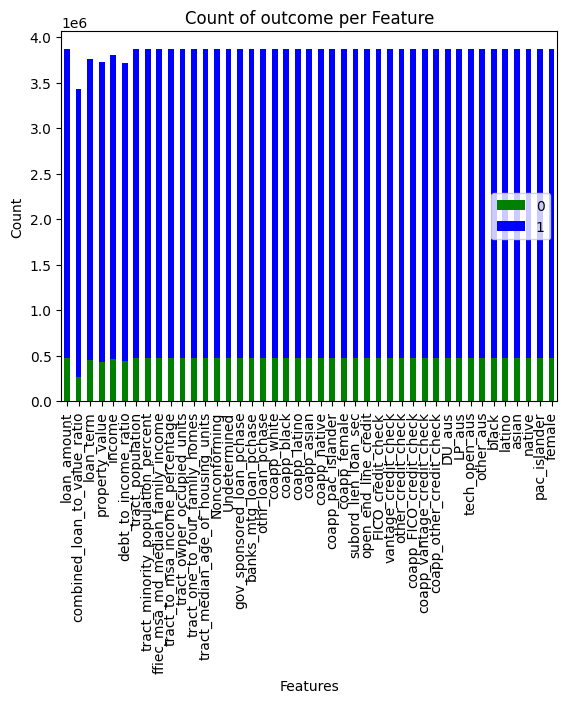

In [26]:
plt.figure(figsize=(5,3))
amv.drop('loan_outcome').plot(kind='bar', stacked=True, color=['green', 'blue'])
# Add Title and Labels
plt.title('Count of outcome per Feature')
plt.xlabel('Features')
plt.ylabel('Count')
plt.legend(loc='right')


### Dealing with NA values

There are many distinct ways of dealing with NA values.

For one, we could have used MICE (Multivariate Imputation) Method https://www.jstatsoft.org/article/view/v045i03 Or we could've used Fast KNN https://impyute.readthedocs.io/en/master/_modules/impyute/imputation/cs/fast_knn.html

Both were tested and given the size of the dataset, MICE didn't converge and Fast KNN was taking too long to process.

Finally, since the dataset has millions of lines, we decided that dropping these lines were not detrimental to the final results

In [27]:
def mice_na_fill(df):

  imputed_training=mice(df.to_numpy(), vis = "monotone", meth = "pmm")
  changed_df= pd.DataFrame(data=imputed_training,columns=df.columns)
  return changed_df

In [28]:
def fastknn_na_fill(df):
  sys.setrecursionlimit(100000)
  imputed_training=fast_knn(df.to_numpy(), k=10)
  changed_df= pd.DataFrame(data=imputed_training,columns=df.columns)
  return changed_df

In [29]:
################
## Not in use ##
################
#X_train = fastknn_na_fill(X_train)


#X_test = X_test.reset_index().dropna()
#X_test.shape
#y_test = y_test.loc[y_test.index.isin(X_test['index'])]

#X_test.drop('index',axis=1, inplace=True) #dropping the added index
#y_test.shape
#y_test.reset_index(drop=True, inplace=True)

In [30]:
################
## Not in use ##
################

  #sys.setrecursionlimit(100000)
  #X_test=fast_knn(X_test, k=10)
  
  #y_train = pd.Series(y_train.to_numpy(), name=y_train.name) #resetting the index for the y_train

In [31]:
#removing the rows containing missing neighbors
hmda_df.dropna(inplace=True)

### Finding Data correlation and Multicollinearity

In [32]:
df_corr = hmda_df.copy() # this is used to be able to correlate categorical features
for cc in ohe_cols:
        df_corr[cc]= df_corr[cc].astype('bool')

Since the Pearson correlation can evaluate only a linear relationship between two continuous variables, we decided Spearman’s rank correlation coefficient. Spearman is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function. The Spearman correlation can evaluate a monotonic relationship between two variables — Continous or Ordinal and it is based on the ranked values for each variable rather than the raw data.

In [33]:
def correlationMatrix(pandas,target=False, method_type='spearman'):
  if target==True:
    correlation_matrix=pandas.corr(method=method_type)
  else:
    pandas = pandas.drop("loan_outcome", axis=1)
    correlation_matrix=pandas.corr(method=method_type)
  return correlation_matrix


def heatMap(corr_matrix,target=False):
  
  if target==True:
    plt.figure(figsize=(8, 6))
    heat = sns.heatmap(corr_matrix[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True)
    
  else:
    plt.figure(figsize=(20, 12))
    heat = sns.heatmap(corr_matrix, vmin=-1, vmax=1,center=0,cmap=sns.diverging_palette(20, 220, n=8),square=True)
  heat.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)
  heat.set_xticklabels(heat.get_xticklabels(), rotation=90,
                       fontsize=8, horizontalalignment='right')
  heat.set_yticklabels(heat.get_yticklabels(),rotation=0,fontsize=8)

In [34]:
#CM=correlationMatrix(df_corr,False)

In [35]:
#plotting the heatmap
#heatMap(CM)

In [36]:
from sklearn.linear_model import LinearRegression
def calculate_vif(df, features):    
    gvif, vif, tolerance = {}, {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
        gvif[feature] = sqrt(vif[feature])
    # return VIF DataFrame
    return pd.DataFrame({'GVIF': gvif, 'VIF': vif, 'Tolerance': tolerance})

Investigating Multicollinearity with method known as GVIF and VIF — General Variance Inflation Factor.

In [37]:
calculate_vif(hmda_df, hmda_df.drop(['loan_outcome'], axis=1).columns).sort_values(by='VIF', ascending=False).head(15)


,GVIF,VIF,Tolerance
DU_aus,56.042570,3140.769646,0.000318
LP_aus,49.932434,2493.247993,0.000401
other_aus,41.236016,1700.409005,0.000588
loan_amount,3.802359,14.457931,0.069166
property_value,3.685160,13.580406,0.073636
tech_open_aus,3.459428,11.967645,0.083559
tract_owner_occupied_units,3.408583,11.618437,0.086070
tract_population,2.703960,7.311397,0.136773
tract_one_to_four_family_homes,2.559705,6.552090,0.152623
coapp_female,1.759273,3.095040,0.323098


Removing some highly collinear variables

In [38]:
calculate_vif(hmda_df, hmda_df.drop(['loan_outcome', 'other_aus', 'tract_owner_occupied_units'], axis=1).columns).sort_values(by='VIF', ascending=False).head(15)


,GVIF,VIF,Tolerance
loan_amount,3.801292,14.449818,0.069205
property_value,3.684404,13.574830,0.073666
tract_population,2.096590,4.395688,0.227496
tract_one_to_four_family_homes,2.038270,4.154546,0.240700
DU_aus,1.816718,3.300464,0.302988
LP_aus,1.775387,3.152001,0.317259
coapp_female,1.759205,3.094802,0.323122
coapp_white,1.741772,3.033769,0.329623
other_credit_check,1.492651,2.228008,0.448831
Nonconforming,1.473751,2.171943,0.460417


In [39]:
#removing Highly collinear columns
hmda_df.drop([ 'other_aus', 'tract_owner_occupied_units'], axis=1, inplace=True)

Verifying the correlation of every variable against the target Loan outcome

In [40]:
hmda_df.drop("loan_outcome", axis=1).apply(lambda x: x.corr(hmda_df.loan_outcome)).sort_values(ascending=True)

gov_sponsored_loan_pchase           -0.269852
debt_to_income_ratio                -0.227681
banks_mtg_loan_pchase               -0.133026
DU_aus                              -0.089570
LP_aus                              -0.073082
othr_loan_pchase                    -0.062794
coapp_white                         -0.061130
coapp_female                        -0.038712
tract_minority_population_percent   -0.036524
FICO_credit_check                   -0.035913
coapp_FICO_credit_check             -0.035853
combined_loan_to_value_ratio        -0.013142
income                              -0.002163
coapp_other_credit_check            -0.001128
coapp_asian                         -0.000686
coapp_pac_islander                   0.001617
coapp_vantage_credit_check           0.002021
coapp_native                         0.002911
pac_islander                         0.003735
asian                                0.006006
female                               0.009237
Nonconforming                     

there is a high correlation between not_high_cost_mtgage, gov_sponsored_loan_pchase and the loan_outcome

### Initiating model testing with the split of Train and test datasets

In [41]:

X=hmda_df.drop('loan_outcome', axis=1)
y=hmda_df['loan_outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1, stratify=y)


### Anomaly value investigation

(Not in use)
Besides outliers, we're going to investigate the dataset for Abnormal values

In [42]:
""" lof_outlier = LocalOutlierFactor(n_neighbors=20, novelty=False)

lof_outlier.fit_predict(X_train) ###############################note: might need to Normalize the data!!!!

prediction_outlier = lof_outlier.negative_outlier_factor_

prediction_outlier """


' lof_outlier = LocalOutlierFactor(n_neighbors=20, novelty=False)\n\nlof_outlier.fit_predict(X_train) ###############################note: might need to Normalize the data!!!!\n\nprediction_outlier = lof_outlier.negative_outlier_factor_\n\nprediction_outlier '

In [43]:
#prediction_outlier = lof_outlier.negative_outlier_factor_

In [44]:
#thresh = quantile(prediction_outlier,.01) #Eliminating the 1% abnormal numbers
#print(thresh)

In [45]:
#index = where(prediction_outlier<=thresh)
#index = pd.DataFrame(index)
#index

In [46]:
#print(X_train.loc[~X_train.index.isin(index)].shape)
#print(y_train.loc[~y_train.index.isin(index)].shape)

In [47]:
#X_train = X_train.loc[~X_train.index.isin(index)]
#y_train = y_train.loc[~y_train.index.isin(index)]

### Handling Data inbalance

Approved Loans: 2473435
Denied Loans: 197662
Proportion: 12.51 : 1


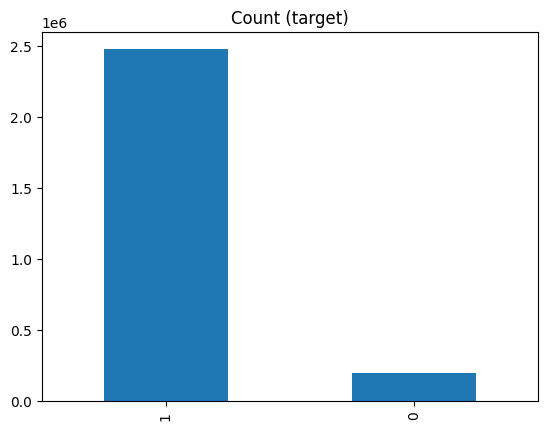

In [48]:
target_count = y_train.value_counts()
print('Approved Loans:', target_count[1])
print('Denied Loans:', target_count[0])
print('Proportion:', round(target_count[1] / target_count[0], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Undersampling Majority Class (approved loans)

In [49]:


def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]

def undersample_majority(X, y, under = 0):
    y_min = y[y == under]
    y_max = y[y != under]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)

    X_under, y_under = sample_together(len(y_min.index), X_max, y_max)
    
    X = pd.concat([X_under, X_min])
    y = pd.concat([y_under, y_min])
    return X, y



def resample(X, y, fraction=0.1):
    X = X.sample(frac=fraction)
    
    y = y.loc[y.index.isin(X.index)]
    print(X.shape, y.shape)
    return X, y

#X_test = X_test.reset_index().dropna()
#X_test.shape
#y_test = y_test.loc[y_test.index.isin(X_test['index'])]

#X_test.drop('index',axis=1, inplace=True) #dropping the added index
#y_test.shape
#y_test.reset_index(drop=True, inplace=True)


In [50]:
#X_test = X_test.reset_index().dropna()
#X_test.shape
#y_test = y_test.loc[y_test.index.isin(X_test['index'])]

#X_test.drop('index',axis=1, inplace=True) #dropping the added index
#y_test.shape
#y_test.reset_index(drop=True, inplace=True)

In [51]:
X_train_bal, y_train_bal = undersample_majority(X_train, y_train)
X_test_bal, y_test_bal = undersample_majority(X_test, y_test)



In [52]:
print(y_train_bal.value_counts())
print(y_test_bal.value_counts())

1    197662
0    197662
Name: loan_outcome, dtype: int64
1    49416
0    49416
Name: loan_outcome, dtype: int64


SMOTENC (Not in use)

In [53]:
def DF_cat_list(df):
    list = []
    for i in range(0,len(df.dtypes)):
        if df.dtypes[i] == "category":
            list.append(i)
    return list    

def smote_resampling(X,y):
    cat_feat_index = DF_cat_list(X)
    smote = SMOTENC(categorical_features= cat_feat_index, random_state=1)
    X_smote, y_smote = smote.fit_resample(X, y)
    return X_smote, y_smote


#CategoricalDtype(categories=[0.0, 1.0], ordered=False)

In [54]:
#Not using SMOTE
#X_sm, y_sm = smote_resampling(X_train,y_train)
#X_sm_test, y_sm_test = smote_resampling(X_test,y_test)

Standarizing features by removing the mean and stardarizing the variance

In [55]:
def standarizer(a):

  scaler = StandardScaler()
  scaler=scaler.fit_transform(a)
  return scaler

def normalizer(a):

  scaler = MinMaxScaler()
  scaler=scaler.fit_transform(a)
  return scaler

In [56]:
continuous_cols = X_train.select_dtypes(exclude=['category']).columns
categorical_cols = X_train.select_dtypes(include=['category']).columns

In [57]:
print('Continuous feature columns are: ' + f'{continuous_cols}')
print('Categorical feature columns are: ' + f'{categorical_cols}')


Continuous feature columns are: Index(['loan_amount', 'combined_loan_to_value_ratio', 'loan_term',
       'property_value', 'income', 'debt_to_income_ratio', 'tract_population',
       'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units'],
      dtype='object')
Categorical feature columns are: Index(['Nonconforming', 'Undetermined', 'gov_sponsored_loan_pchase',
       'banks_mtg_loan_pchase', 'othr_loan_pchase', 'coapp_white',
       'coapp_black', 'coapp_latino', 'coapp_asian', 'coapp_native',
       'coapp_pac_islander', 'coapp_female', 'subord_lien_loan_sec',
       'open_end_line_credit', 'FICO_credit_check', 'vantage_credit_check',
       'other_credit_check', 'coapp_FICO_credit_check',
       'coapp_vantage_credit_check', 'coapp_other_credit_check', 'DU_aus',
       'LP_aus', 'tech_open_aus', 'black', 'latino', 'asian', 'native',
       'pac_i

Applying the dataframeMapper to transform only the continuous columns in the Dataframe

In [58]:
mapper = DataFrameMapper(
    [([continuous_col], StandardScaler()) for continuous_col in continuous_cols] +
    [([categorical_col], None) for categorical_col in categorical_cols]
    ,df_out=True
    )



In [59]:
X_train_std = mapper.fit_transform(X_train_bal)
X_test_std = mapper.fit_transform(X_test_bal)


In [79]:
X_test_std.rename(columns={'debt_to_income_ratio': 'dti_std'})['dti_std']


2964760    0.629357
3699841   -0.065946
3611392   -1.456553
555015    -1.070274
1316590    0.783869
             ...   
2521169   -0.452226
428702     0.320333
2453329    2.019964
869322    -1.456553
1220395   -1.070274
Name: dti_std, Length: 98832, dtype: float64

In [82]:
DTI = pd.concat([X_test_bal.rename(columns={'debt_to_income_ratio': 'dti'})['dti'],
          X_test_std.rename(columns={'debt_to_income_ratio': 'dti_std'})['dti_std']], axis=1)


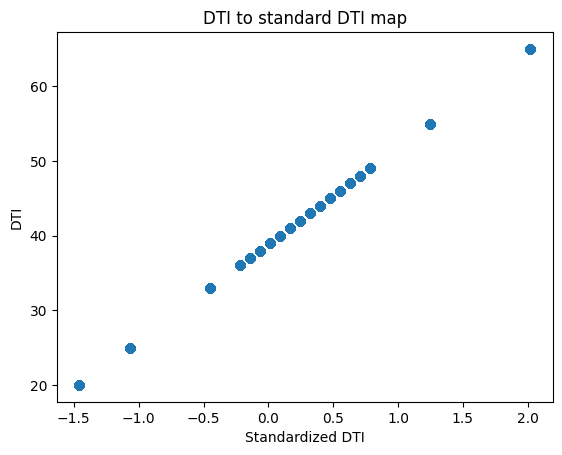

In [85]:
plt.scatter(DTI['dti_std'], DTI['dti'])
plt.title('DTI to standard DTI map')
plt.xlabel('Standardized DTI')
plt.ylabel('DTI')
plt.show()


In [65]:
X_train_GS, y_train_GS = resample(X_train_std, y_train_bal, fraction=0.1)
print(y_train_GS.value_counts())


(39532, 41) (39532,)
1    19799
0    19733
Name: loan_outcome, dtype: int64


### Model Parameter Optimization

Since we'll be using some blackbox models, we'll attempt to optimize their parameters

In [61]:
model_params = {
    'MLP': {
        'model': MLPClassifier(),
        'params' : {
            'hidden_layer_sizes' : [(1500,3)],
            'alpha': np.geomspace(1e-6,1e-3, 15, endpoint = True),
            'learning_rate_init': np.geomspace(1e-5,1e-3, 15, endpoint = True),
            'max_iter':np.linspace(500,1500,num=5, dtype=int),
            'verbose':[False]
            }
        },
    'RandForrest': {
        'model': RandomForestClassifier(),
        'params' : {
            'bootstrap': [True],
            "n_estimators": np.linspace(100,1000,num=10, dtype=int),
            "max_depth": [80,90,100,None],
            #"criterion":["gini"],
            "min_samples_split": [2,4,8],
            "min_samples_leaf": [1,2,3,4,5]
            #"class_weight":["balanced","balanced_subsample",None]   
            }
        },
    
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    }
}

In [67]:
 
scores = []

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], n_iter=30, cv=5, return_train_score=False)
    clf.fit(X_train_GS, y_train_GS)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
model_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
model_df 

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dani

,model,best_score,best_params
0,MLP,0.502884,"{'verbose': False, 'max_iter': 1500, 'learning..."
1,RandForrest,0.506147,"{'n_estimators': 200, 'min_samples_split': 2, ..."
2,svm,0.500936,"{'kernel': 'rbf', 'C': 20}"


In [68]:
model_df.to_csv('../../notebooks/model_param_optimization.csv', index = False)

In [63]:
# Calculating accuracy, F1-score views
def metrics(y_pred, y_true, model_name=None):
  report = classification_report(y_true, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df2 = df.reset_index().melt('index')
  df2['index0'] = df2['variable'].astype('str') +'_'+ df2['index'].astype('str')
  df2 = df2.pivot_table(values='value', columns='index0', aggfunc='first').reset_index(drop=True)
  df2.insert(loc=0, column='model', value=model_name)
  return df2


Copying the best parameters from Randon Search into the models below

In [64]:

def step_func(x):
    if x > 0.5:
        return 1
    else:
        return 0

def DecisionT(X_train, y_train,X_test,y_test, model_name='Decision Tree'):

  deCls=DecisionTreeClassifier(max_depth=15,max_features=5,min_samples_leaf=2,min_samples_split=5, random_state=1)
  deCls.fit(X_train, y_train)
  predictions = deCls.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return deCls, df

def LogRegre(X_train, y_train,X_test,y_test, model_name='Log Regression'):

  logReg = LogisticRegression(solver="saga", tol=1e-3, random_state=1)
  logReg.fit(X_train, y_train)
  predictions = logReg.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return logReg, df
  

def RandFor(X_train, y_train,X_test,y_test, model_name='Random Forest'):

  randF = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_leaf=2,
                                 min_samples_split=8, n_estimators=200, random_state=1)
  randF.fit(X_train, y_train)
  predictions = randF.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return randF, df

def kNeighbors(X_train, y_train,X_test,y_test, model_name='KNN'):

  kN = KNeighborsClassifier(
      n_neighbors=161, p=2, weights="distance", metric="manhattan", random_state=1)
  kN.fit(X_train, y_train)
  predictions = kN.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return kN, df

def support_vector(X_train, y_train,X_test,y_test, model_name='SVC'):

  sv = SVC(kernel='linear', C=10)
  sv.fit(X_train, y_train)
  predictions = sv.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return sv, df

def mlp(X_train, y_train,X_test,y_test, model_name='MLP'):

  ml = MLPClassifier(alpha=0.001, hidden_layer_sizes=(
      1500, 3), learning_rate_init=3.727593720314938e-05, max_iter=1000, verbose=False, random_state=1)
  ml.fit(X_train, y_train)
  predictions = ml.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return ml, df

def ebm(X_train, y_train,X_test,y_test,feat_names=None,feat_dtypes=None, model_name='Explainable Boosting'):

  eb = ExplainableBoostingClassifier(feature_names= feat_names, feature_types=feat_dtypes, random_state=1)
  eb.fit(X_train, y_train)
  predictions = eb.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return eb, df

def stats_logit(X_train, y_train,X_test,y_test, model_name='Stats Logistics'):

  log = sm.Logit(y_train, X_train, random_state=1).fit()
  predictions = log.predict(X_test)
  predictions = np.vectorize(step_func)(predictions)
  df = metrics(predictions,y_test, model_name)
  return log, df



We'll take as a next step, a Decision tree, a Logistic Regression, the previously optimized Random Forest and MLP and add the Explainable Boosting Machine

In [65]:
print("Classification Report Decision Tree", flush=True)
model_DT, DT_results = DecisionT(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='Decision Tree')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)

print("Classification Report Logistics Reg", flush=True)
model_LR, LR_results = stats_logit(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='Logistic Regression')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)
 
print("Classification Report Random Forest", flush=True)
model_RF, RF_results = RandFor(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='Random Forest')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)


print("Classification Report EBM", flush=True)
model_EB, EB_results = ebm(X_train_std, y_train_bal,X_test_std,y_test_bal,X.columns, model_name='EBM')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)


print("Classification Report MLP", flush=True)
model_ML, ML_results = mlp(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='MLP')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)



Classification Report Decision Tree
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report Logistics Reg


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.264275
         Iterations 13
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report Random Forest
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report EBM
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report MLP
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+


### exporting the models to file

In [70]:
import pickle

models = ['model_DT', 'model_LR', 'model_RF', 'model_EB', 'model_ML'
         ]
ID= '_1121'
for i in models:
    exec('model=' + i)
    filename = '../../notebooks/' + i + ID + '.sav'
    pickle.dump(model, open(filename, 'wb'))


### Plotting and saving results

In [71]:
results=[DT_results, LR_results, RF_results, EB_results, ML_results
         ]
results_df = pd.DataFrame(columns=DT_results.columns)
for i in results:
    results_df = results_df.append(i, ignore_index=True)
results_df.to_csv('../../notebooks/model_results.csv', index = False)
results_df.sort_values(by='f1-score_accuracy', ascending=False)


C:\Users\danie\AppData\Local\Temp\ipykernel_3988\1399997037.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(i, ignore_index=True)


index0,model,f1-score_0,f1-score_1,f1-score_accuracy,f1-score_macro avg,f1-score_weighted avg,precision_0,precision_1,precision_accuracy,precision_macro avg,...,recall_0,recall_1,recall_accuracy,recall_macro avg,recall_weighted avg,support_0,support_1,support_accuracy,support_macro avg,support_weighted avg
3,EBM,0.898276,0.879065,0.889499,0.888671,0.888671,0.832180,0.970726,0.889499,0.901453,...,0.975777,0.803222,0.889499,0.889499,0.889499,49416.0,49416.0,0.889499,98832.0,98832.0
2,Random Forest,0.898332,0.878035,0.889105,0.888184,0.888184,0.829326,0.975399,0.889105,0.902362,...,0.979865,0.798345,0.889105,0.889105,0.889105,49416.0,49416.0,0.889105,98832.0,98832.0
1,Logistic Regression,0.893522,0.869028,0.882538,0.881275,0.881275,0.817114,0.981974,0.882538,0.899544,...,0.985693,0.779383,0.882538,0.882538,0.882538,49416.0,49416.0,0.882538,98832.0,98832.0
4,MLP,0.880625,0.871180,0.876083,0.875903,0.875903,0.849484,0.907064,0.876083,0.878274,...,0.914137,0.838028,0.876083,0.876083,0.876083,49416.0,49416.0,0.876083,98832.0,98832.0
0,Decision Tree,0.820234,0.754920,0.792598,0.787577,0.787577,0.723789,0.922506,0.792598,0.823147,...,0.946333,0.638862,0.792598,0.792598,0.792598,49416.0,49416.0,0.792598,98832.0,98832.0


In [66]:
X_test_std.shape


(98832, 41)

In [68]:
y_test_bal.shape


(98832,)

In [71]:
test_df = pd.concat([X_test_std, y_test_bal], axis=1)


Exporting file for Model Analysis

In [73]:
test_df.to_csv(
    '../../data/hmda_lar/cleaned_data/2_analysis_hmda_stage2.csv', index=False)
